In [1]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


# Trash Classification


### Import Library

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
import os
from datasets import load_dataset
from PIL import Image
from collections import Counter
import random
import seaborn as sns
import wandb


## Data Preperation

In [3]:
dataset = load_dataset("garythung/trashnet")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

dataset-original.zip:   0%|          | 0.00/3.63G [00:00<?, ?B/s]

dataset-resized.zip:   0%|          | 0.00/42.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5054 [00:00<?, ? examples/s]

In [4]:
# Define the base directory for saving organized image data
base_dir = './trash_data'
os.makedirs(base_dir, exist_ok=True) # Ensure the base directory exists (create it if it doesn't)
# Retrieve label names from the dataset
label_name = dataset['train'].features['label'].names
# Create subdirectories for each label in the base directory
for label in label_name:
  os.makedirs(os.path.join(base_dir, label), exist_ok=True)

#Save each image according to its label
for i,example in enumerate(dataset['train']):
  image = example['image']
  label = example['label']
  image.save(os.path.join(base_dir, label_name[label], f'{i}.jpg'))# Save the image in the folder corresponding to its label, with a unique filename


### Augmentation and Splitting

In [5]:
# Initialize an ImageDataGenerator for training data with data augmentation
train_datagen = ImageDataGenerator(
                    rescale=1./255,              # Normalize pixel values to the range [0, 1]
                    rotation_range=20,           # Randomly rotate images by up to 20 degrees
                    horizontal_flip=True,        # Allow random horizontal flipping of images
                    shear_range=0.2,             # Apply random shearing transformations
                    zoom_range=0.2,              # Randomly zoom in/out on images
                    fill_mode='nearest',         # Fill in missing pixels after transformations
                    validation_split=0.3         # Reserve 30% of data for validation
                    )

# Initialize a separate ImageDataGenerator for validation data (no augmentation)
test_datagen = ImageDataGenerator(
                    rescale=1./255,              # Normalize pixel values to the range [0, 1]
                    validation_split=0.3         # Match the validation split
                    )


In [6]:
# Create a training data generator
train_generator = train_datagen.flow_from_directory(
        base_dir,                    # Directory containing the organized images
        target_size=(150, 150),      # Resize all images to 150x150 pixels
        batch_size=32,               # Process images in batches of 32
        class_mode='categorical',    # For multi-class classification
        subset='training'            # Use the training subset
        )

# Create a validation data generator
validation_generator = test_datagen.flow_from_directory(
        base_dir,                    # Directory containing the organized images
        target_size=(150, 150),      # Resize all images to 150x150 pixels
        batch_size=32,               # Process images in batches of 32
        class_mode='categorical',    # For multi-class classification
        subset='validation'          # Use the validation subset
        )

Found 3540 images belonging to 6 classes.
Found 1514 images belonging to 6 classes.


## Exploratory Image Analysis

In [7]:
# Displays the label name along with its index number.
label_names = dataset['train'].features['label'].names

print("Label List:")
for idx, label_name in enumerate(label_names):
    print(f"{idx} = {label_name}")


Label List:
0 = cardboard
1 = glass
2 = metal
3 = paper
4 = plastic
5 = trash


In [8]:
# Calculate and display the number of samples per class
label_counts = Counter(dataset['train']['label'])
print("Number of images per class:")
for label, count in label_counts.items():
    print(f"{label_names[label]}: {count} images")


Number of images per class:
cardboard: 806 images
glass: 1002 images
metal: 820 images
paper: 1188 images
plastic: 964 images
trash: 274 images


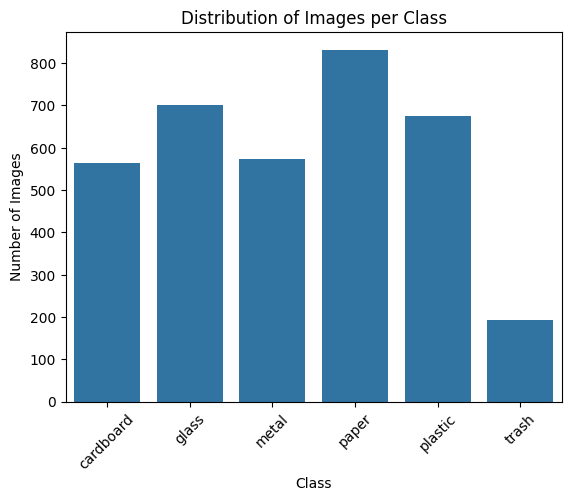

In [9]:
# Visualize the class distribution in the training data
class_counts = train_generator.classes
class_labels = list(train_generator.class_indices.keys())

sns.countplot(x=class_counts)
plt.xticks(range(len(class_labels)), class_labels, rotation=45)
plt.title('Distribution of Images per Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


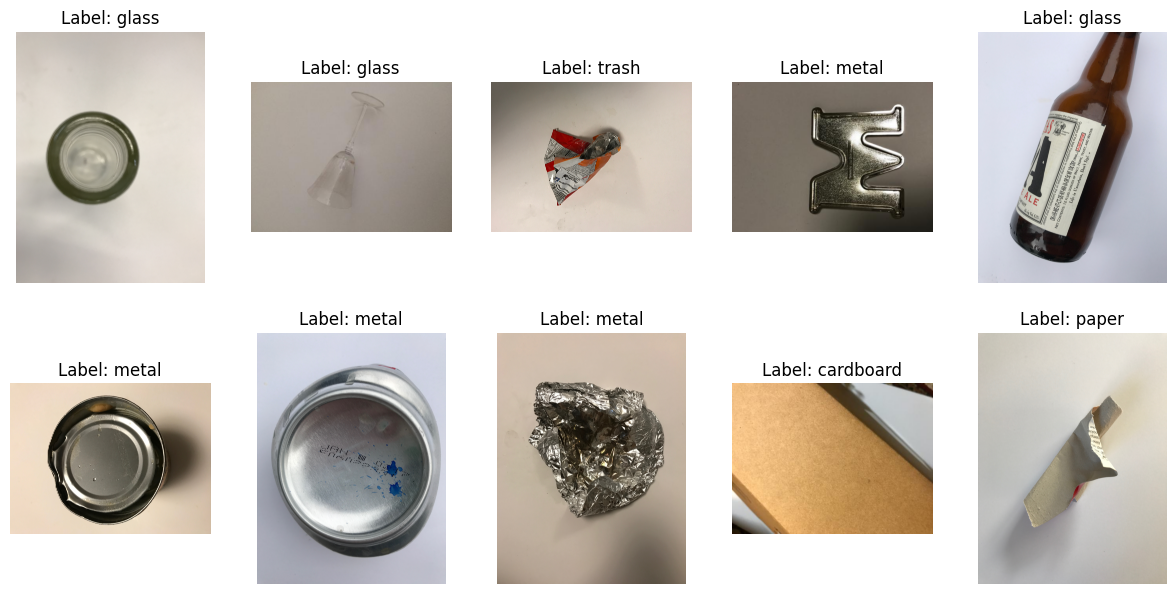

In [10]:
def show_random_images(dataset, num_samples=10):
    random_indices = random.sample(range(len(dataset['train'])), num_samples)

    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(random_indices):
        sample = dataset['train'][idx]
        image = sample['image']
        label = sample['label']

        plt.subplot(4, 5, i + 1)
        plt.imshow(image)
        plt.title(f"Label: {label_names[label]}")
        plt.axis("off")
    plt.show()

# Display 10 random samples
show_random_images(dataset)


## Model Training and Evaluation Analysis

In [11]:
# Login to Weights & Biases (wandb) for experiment tracking
wandb.login()

# Initialize a new wandb project and set configuration parameters
wandb.init(
    project="trash_classification",  # Project name
    config={
        "config.concept": "cnn",      # Model concept: Convolutional Neural Network
        "dropout": 0.25,             # Dropout rate to reduce overfitting
        "loss": "categorical_crossentropy",  # Loss function for multi-class classification
        "metric": "accuracy",        # Metric to evaluate the model
        "epoch": 30,                 # Number of epochs for training
        "batch_size": 64             # Batch size for training
    }
)
config = wandb.config  # Access configuration parameters


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [20]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(config.dropout),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(config.dropout),#dropout layer untuk mengurangi overfitting
    tf.keras.layers.Dense(6, activation='softmax')
])

In [21]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │      12,846,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │           6,150 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,240,646 (50.51 MB)

 Trainable params: 13,240,646 (50.51 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001),
              loss= config.loss,
              metrics=[config.metric])

In [23]:
class WandbCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Log training and validation metrics at the end of each epoch
        wandb.log({
            'epoch': epoch,
            'loss': logs['loss'],
            'accuracy': logs['accuracy'],
            'val_loss': logs['val_loss'],
            'val_accuracy': logs['val_accuracy']
        })

In [24]:
model.fit(
      train_generator,
      epochs = config.epoch,
      batch_size=config.batch_size,
      validation_data=validation_generator,
      verbose=1,
      callbacks= [WandbCallback(),tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)

Epoch 1/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 478s 4s/step - accuracy: 0.2885 - loss: 1.6515 - val_accuracy: 0.4419 - val_loss: 1.3806
Epoch 2/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 465s 4s/step - accuracy: 0.4491 - loss: 1.3497 - val_accuracy: 0.5165 - val_loss: 1.2603
Epoch 3/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 459s 4s/step - accuracy: 0.5289 - loss: 1.2120 - val_accuracy: 0.5495 - val_loss: 1.2313
Epoch 4/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 478s 4s/step - accuracy: 0.5571 - loss: 1.1519 - val_accuracy: 0.5839 - val_loss: 1.0930
Epoch 5/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 448s 4s/step - accuracy: 0.5999 - loss: 1.0641 - val_accuracy: 0.6262 - val_loss: 1.0092
Epoch 6/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 482s 4s/step - accuracy: 0.6437 - loss: 0.9604 - val_accuracy: 0.5984 - val_loss: 1.0839
Epoch 7/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 451s 4s/step - accuracy: 0.6642 - loss: 0.8979 - val_accuracy: 0.5964 - val_loss: 1.0888
Epoch 8/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 440s 4s/step - accuracy: 0.6760 - loss: 0.8538 - val_accu

In [25]:
loss, accuracy = model.evaluate(validation_generator, verbose=2)
print('Accuracy:', accuracy , 'Loss:', loss)


48/48 - 95s - 2s/step - accuracy: 0.7675 - loss: 0.7456
Accuracy: 0.7675033211708069 Loss: 0.7456380128860474


In [26]:
wandb.finish()

accuracy,▁▃▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇██▇███
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,█▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁
val_accuracy,▁▂▃▄▅▄▄▆▆▆▆▆▇▆▇▆█▇██▇█▇
val_loss,█▇▇▅▅▅▅▃▃▃▃▃▂▃▂▃▁▂▂▁▃▁▂
accuracy,0.88814
epoch,22
loss,0.31635
val_accuracy,0.7675
val_loss,0.74564


Tracking with Wandb
